In [11]:
import numpy as np
import astropy
from astropy.table import Table, Column, vstack
from astropy import units as u
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.coordinates import SkyCoord, search_around_sky
from IPython.display import clear_output
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import scipy.stats
import pickle
import os
from pymoc.util import catalog
from pymoc import MOC
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random
import pyvo as vo
from time import sleep

from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model

import emcee
import time
import corner
from heapq import nsmallest
import subprocess


In [7]:
#returns the redshifted frequency of a source given the redshift of the source and the restframe frequency
def redshifted(z,f0):
    return(f0/(z+1))

#returns the CO1-0 emission line luminosity from the LIR luminosity using the relation for the MS found in 
#Walter&Carilli2013 section 4 (i think?)
def CO_from_Ldust_MS(L):
    return( 10**((np.log10(L)-0.53)/1.13) )

#returns the CO1-0 emission line luminosity from the LIR luminosity using the relation for all sources found in 
#Walter&Carilli2013 section 4 (i think?)
def CO_from_Ldust_all(L):
    return( 10**((np.log10(L)+1.74)/1.37) )

#finds the linewidth of a emission line given the rotational velocity of the galaxy, the redshift 
#and the rest frame frequency
def linewidth(f0,v,z):
    c = 3e5
    fshift1 = redshifted(z,c/(c+v)*f0)
    fshift2 = redshifted(z,c/(c-v)*f0)
    return(fshift2-fshift1)

#returns the linebrightness of a source given its line luminosity the distance to the source, its redshift and
#the observed frequnecy of the line
def linebrightness(L,d,z,f):
    nume = (1+z)**3 * f**2 * L
    denom = 3.25e7*d**2
    return(nume/denom)

In [32]:
#estimate time needed to observe a source to get to the given rms
def obs_time(rms):
    if len(rms) == 1:
        rms = rms[0]
        if rms<0.1768:
            obs_time = 2*(rms/0.1768)**-2
            return(obs_time)
        if rms>0.331:
            return(1.0)
        if (rms<0.331) & (rms>0.240):
            return(1.2)
        if (rms<0.240) & (rms>0.206):
            return(1.5)
        if (rms<0.206) & (rms>0.177):
            return(1.85)
    else:
        hours = 0
        for val in rms:
            if val<0.1768:
                obs_time = 2*(val/0.1768)**-2
                hours = hours + obs_time
            if val>0.331:
                hours = hours + 1.0
            if (val<0.331) & (val>0.240):
                hours = hours+1.2
            if (val<0.240) & (val>0.206):
                hours = hours + 1.5
            if (val<0.206) & (val>0.177):
                hours = hours + 1.85
        return(hours)

In [33]:
#function to find the maximum n values in an array because i couldn't find a function to do this already
def find_n_max(array):
    if np.shape(array) == ():
        return([0])
    
    else:
        high1 = 1e-99
        ind = 0
        index = []
        for n,val in enumerate(array):
            if val>high1:
                high1=val
                ind = n
        index.append(ind)
        high2 = 1e-99
        ind2 = 0
        for n,val in enumerate(array):
            if (val>high2) & (val<high1):
                high2 = val
                ind = n
        index.append(ind)
    return(index)

In [49]:
#plots the sources in a given luminosity range on the sSFR-Tdust plane
def target_select(cands,llow,lhigh):
    
    tmid = 33
    ssfrmid = 2e-9
    
    lir_mask = np.log10(cands['cigale_dustlumin']/3.8e26)
    mask = (lir_mask>llow) & (lir_mask<lhigh)
    fig, ax1 = plt.subplots()
    #ax1.set_yscale('log')
    ax1.set_xscale('log')
    lir = cands[mask]['cigale_dustlumin']/3.8e26
    lirerr = cands[mask]['cigale_dustlumin_err']/3.8e26
    x = cands[mask]['cigale_sfr']/cands[mask]['cigale_mstar']
    xerr = np.sqrt(x**2*((cands[mask]['cigale_sfr']/cands[mask]['cigale_sfr_err'])**2 + (cands[mask]['cigale_mstar']/cands[mask]['cigale_mstar_err'])**2)**-1)
    y = cands[mask]['peak_wavelength']/1000
    
    ax1.errorbar(x,y,xerr=xerr,fmt='o')
    for n in range(len(cands[mask])):
        label = '{}h'.format(np.round(obs_time([cands['rms'][mask][n]]),2))
        ax1.annotate(label,(x[n],y[n]))
    ax1.set_xlabel('sSFR')
    ax1.set_ylabel('peak_wavelength (um)')
    ax1.set_yticks(np.linspace(157, 314, 5))
    ax1.set_ylim(157,314)

    ax2 = ax1.twinx()
    ax2.tick_params(axis='y')
    ytick = np.round(np.interp(np.linspace(157,314,5),np.flip(temp_conv['col2'],0),np.flip(temp_conv['col1'],0)),1)
    ax2.set_yticks(np.linspace(22,44,5))
    ax2.set_yticklabels(np.flip(ytick,0))
    ax2.invert_yaxis()
    ax2.set_ylim(min(ytick),max(ytick))
    ax2.set_ylabel('temperature (K)')
    ax1.set_title('{}<Ldust<{}'.format(llow,lhigh))
    fig.tight_layout()
    plt.gca().invert_yaxis()
    
    targets = Table(cands[0])
    quad = (cands['cigale_sfr']/cands['cigale_mstar']<ssfrmid) & (cands['temp_est']<tmid) & (lir_mask>llow) & (lir_mask<lhigh)
    targets = quad_calc(cands,quad,ax1,targets)
    targets.remove_row(0)
    print('for {}<Ldust<{} there are {} sources with sSFR<{} and T<{} which would take {} hours to observe'.format(llow,lhigh,len(cands[quad]),ssfrmid,tmid,obs_time(cands['rms'][quad])))
    
    quad = (cands['cigale_sfr']/cands['cigale_mstar']>ssfrmid) & (cands['temp_est']<tmid) & (lir_mask>llow) & (lir_mask<lhigh)
    targets = quad_calc(cands,quad,ax1,targets)
    print('for {}<Ldust<{} there are {} sources with sSFR>{} and T<{} which would take {} hours to observe'.format(llow,lhigh,len(cands[quad]),ssfrmid,tmid,obs_time(cands['rms'][quad])))
    
    quad = (cands['cigale_sfr']/cands['cigale_mstar']<ssfrmid) & (cands['temp_est']>tmid) & (lir_mask>llow) & (lir_mask<lhigh)
    targets = quad_calc(cands,quad,ax1,targets)
    print('for {}<Ldust<{} there are {} sources with sSFR<{} and T>{} which would take {} hours to observe'.format(llow,lhigh,len(cands[quad]),ssfrmid,tmid,obs_time(cands['rms'][quad])))
    
    quad = (cands['cigale_sfr']/cands['cigale_mstar']>ssfrmid) & (cands['temp_est']>tmid) & (lir_mask>llow) & (lir_mask<lhigh)
    targets = quad_calc(cands,quad,ax1,targets)
    print('for {}<Ldust<{} there are {} sources with sSFR>{} and T>{} which would take {} hours to observe'.format(llow,lhigh,len(cands[quad]),ssfrmid,tmid,obs_time(cands['rms'][quad])))
    plt.show()
    return(targets)

#returns the 2 brightest sources in a given quadrant
def quad_calc(cands,quad,ax1,targets):
    
    if np.sum(quad) == 0:
        return(targets)
    
    temp = Table(cands[0])
    #print(temp)
    ind = find_n_max(cands[quad]['line_brightness'])
    #print(ind)
    temp.add_row(cands[quad][ind][0])
    temp.add_row(cands[quad][ind][1])
    #print(temp)
    temp.remove_row(0)
    if len(np.unique(ind))==1:
        temp.remove_row(1)
    #print(temp)
    x = cands[quad][ind]['cigale_sfr']/cands[quad][ind]['cigale_mstar']
    xerr = np.sqrt(x**2*((cands[quad][ind]['cigale_sfr']/cands[quad][ind]['cigale_sfr_err'])**2 + (cands[quad][ind]['cigale_mstar']/cands[quad][ind]['cigale_mstar_err'])**2)**-1)
    y = cands[quad][ind]['peak_wavelength']/1000
    ax1.errorbar(x,y,xerr=xerr,fmt='o',color='red')
    #print(temp)
    temp = vstack([targets,temp])
    return(temp)

load the data from the VO server. We are only looking in the five fields because from previous inspection these are the only visible fields with cigale run on them. We return sources between 1.19<z<1.31 and that have cigale SEDs

In [2]:
fields = [
'COSMOS',
'ELAIS-N1',
'GAMA-09',
'GAMA-12',
'GAMA-15',]

service = vo.dal.TAPService("https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap")

result = []
for n,field in enumerate(fields):

    query="""
SELECT help_id, ra, dec, redshift, zspec, zspec_association_flag, f_mips_24, ferr_mips_24, f_pacs_green, ferr_pacs_green, f_pacs_red, ferr_pacs_red, f_spire_250, ferr_spire_250, f_spire_350, ferr_spire_350, f_spire_500, ferr_spire_500, cigale_dustlumin, cigale_dustlumin_err, cigale_mstar, cigale_mstar_err, cigale_sfr, cigale_sfr_err, field
FROM herschelhelp.main
WHERE (
herschelhelp.main.redshift BETWEEN 1.19 AND 1.31 AND
herschelhelp.main.cigale_dustlumin>1 AND
herschelhelp.main.field='{}'
)""".format(field)

    job = service.submit_job(query)
    job.run()
    
    while job.phase == "EXECUTING":
        print("Job running in {}...".format(field))
        sleep(5)
    
    table = job.fetch_result().to_table()

    job.delete()
    
    if n==0:
        result=table
    else:
        result = astropy.table.vstack([result,table],join_type='outer')

Job running in COSMOS...
Job running in COSMOS...
Job running in COSMOS...
Job running in COSMOS...
Job running in COSMOS...


Job running in ELAIS-N1...
Job running in ELAIS-N1...
Job running in ELAIS-N1...


Job running in GAMA-09...
Job running in GAMA-09...
Job running in GAMA-09...
Job running in GAMA-09...
Job running in GAMA-09...
Job running in GAMA-09...
Job running in GAMA-09...
Job running in GAMA-09...
Job running in GAMA-09...
Job running in GAMA-09...


Job running in GAMA-12...
Job running in GAMA-12...
Job running in GAMA-12...
Job running in GAMA-12...
Job running in GAMA-12...
Job running in GAMA-12...
Job running in GAMA-12...
Job running in GAMA-12...
Job running in GAMA-12...
Job running in GAMA-12...


Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...
Job running in GAMA-15...


limit the returned sources to 1.2<z<1.3 confirmed by both zspec and photoz and require that it have a zspec and that they agree with the photoz within 0.1. Sources were then limited to COSMOS in as this is an observable field and has enough sources to cover a range of parameter space.

In [51]:
mask = (result['field'] == b'COSMOS') & (result['redshift']-result['zspec'] < 0.1) & (result['redshift']>=1.2) & (result['redshift']<=1.3) & (result['zspec']>=1.2) & (result['zspec']<=1.3)
cands = result[mask]
mask = cands['field']==b'COSMOS'
cands = cands[mask]

/Users/im281/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)
/Users/im281/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)


Calculate the rms needed to observe each source

In [52]:
#list the frequencies of the CO transitions
CO1 = 115.3
CO2 = 2*CO1
CO3 = 3*CO1
z = cands['zspec']
f = redshifted(z,CO2)

d = cosmo.luminosity_distance(z).value
L = cands['cigale_dustlumin']/3.8e26
L = CO_from_Ldust_all(L)*0.7

#calculate the rms level needed to observe the given source
linebright = linebrightness(L,d,z,f)/300/5
np.percentile(linebright,[85,50,15])
linebricol = Column(linebright*5*1000,name='line_brightness',unit='mJy')
rmscol = Column(linebright*1000,name='rms',unit='mJy')
cands.add_column(linebricol)
cands.add_column(rmscol)

download the SEDs of all the candidates

In [54]:
for n in range(len(cands)):
    field = str(cands[n]['field'])[2:-1]
    helpid = str(cands[n]['help_id'])[2:-1]
    url = 'http://hedam.lam.fr/HELP/dataproducts/dmu28/dmu28_{}/data/zphot/SEDs/fits/{}_best_model.fits'.format(field,helpid)
    #print(url)
    subprocess.call(['curl','-O',url])

In [55]:
for n in range(len(cands)):
    field = str(cands[n]['field'])[2:-1]
    helpid = str(cands[n]['help_id'])[2:-1]
    url = 'http://hedam.lam.fr/HELP/dataproducts/dmu28/dmu28_{}/data/zphot/SEDs/png/{}_best_model.png'.format(field,helpid)
    #print(url)
    subprocess.call(['curl','-O',url])

read in the peak wavelength of each SED

In [56]:
peak_wav = []
for name in cands['help_id']:
    ids = str(name)[2:-1]
    fname = '{}_best_model.fits'.format(ids)
    try:
        sed = Table.read(fname)
    except:
        print(fname)
        continue
    mask = (sed['wavelength']>50e3) & (sed['wavelength']<500e3)
    max_wav = np.argmax(sed['Fnu'][mask])
    peak_wav.append(sed[mask][max_wav]['wavelength'])

read in a conversion table from peak wavelength to temperature created from Casey2012 templates and work out the temperature of each source

In [57]:
temp_conv = Table.read('test.dat',format='ascii')

In [58]:
temp_est = []
for val in peak_wav:
    min_index = np.argmin(np.abs(temp_conv['col2'] - val/1000))
    temp_est.append(temp_conv['col1'][min_index])
temp_est = Column(temp_est,name='temp_est',unit='K')
peak_wav = Column(peak_wav,name='peak_wavelength',unit='nm')
cands.add_column(peak_wav)
cands.add_column(temp_est)

for 11.2<Ldust<11.6 there are 2 sources with sSFR<2e-09 and T<33 which would take 16.229516829046034 hours to observe
for 11.2<Ldust<11.6 there are 0 sources with sSFR>2e-09 and T<33 which would take 0 hours to observe
for 11.2<Ldust<11.6 there are 0 sources with sSFR<2e-09 and T>33 which would take 0 hours to observe
for 11.2<Ldust<11.6 there are 1 sources with sSFR>2e-09 and T>33 which would take 4.031311675654418 hours to observe


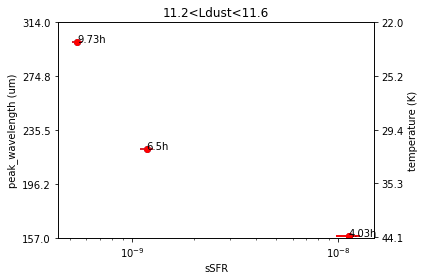

for 11.6<Ldust<11.8 there are 5 sources with sSFR<2e-09 and T<33 which would take 13.673666035229514 hours to observe
for 11.6<Ldust<11.8 there are 1 sources with sSFR>2e-09 and T<33 which would take 2.9539067266610366 hours to observe
for 11.6<Ldust<11.8 there are 5 sources with sSFR<2e-09 and T>33 which would take 17.074821407599796 hours to observe
for 11.6<Ldust<11.8 there are 3 sources with sSFR>2e-09 and T>33 which would take 10.753827805481485 hours to observe


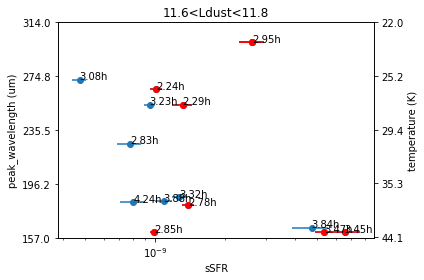

for 11.8<Ldust<12.0 there are 3 sources with sSFR<2e-09 and T<33 which would take 5.7375520949691765 hours to observe
for 11.8<Ldust<12.0 there are 1 sources with sSFR>2e-09 and T<33 which would take 1.85 hours to observe
for 11.8<Ldust<12.0 there are 4 sources with sSFR<2e-09 and T>33 which would take 6.699999999999999 hours to observe
for 11.8<Ldust<12.0 there are 2 sources with sSFR>2e-09 and T>33 which would take 3.05 hours to observe


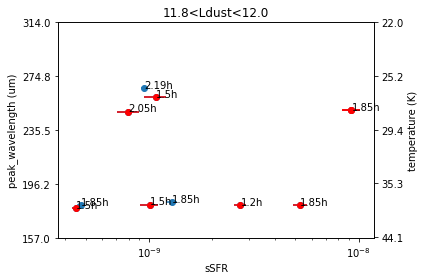

for 12.0<Ldust<12.4 there are 2 sources with sSFR<2e-09 and T<33 which would take 2.2 hours to observe
for 12.0<Ldust<12.4 there are 0 sources with sSFR>2e-09 and T<33 which would take 0 hours to observe
for 12.0<Ldust<12.4 there are 2 sources with sSFR<2e-09 and T>33 which would take 2.7 hours to observe
for 12.0<Ldust<12.4 there are 2 sources with sSFR>2e-09 and T>33 which would take 2.4 hours to observe


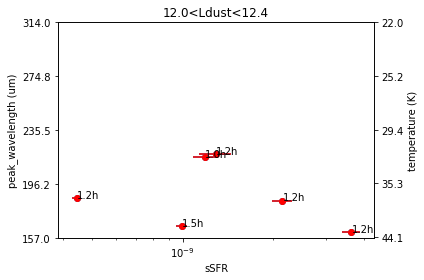

In [59]:
targets = Table(cands[0])
targets = vstack([targets,target_select(cands,11.2,11.6)])
targets.remove_row(0)
targets = vstack([targets,target_select(cands,11.6,11.8)])
targets = vstack([targets,target_select(cands,11.8,12.0)])
targets = vstack([targets,target_select(cands,12.0,12.4)])

now we have a table of the sources we will observe

In [60]:
targets

help_id,ra,dec,redshift,zspec,zspec_association_flag,f_mips_24,ferr_mips_24,f_pacs_green,ferr_pacs_green,f_pacs_red,ferr_pacs_red,f_spire_250,ferr_spire_250,f_spire_350,ferr_spire_350,f_spire_500,ferr_spire_500,cigale_dustlumin,cigale_dustlumin_err,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,field,line_brightness,rms,peak_wavelength,temp_est
,deg,deg,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,W,W,Msun,Msun,Msun / yr,Msun / yr,,mJy,mJy,nm,K
object,float64,float64,float32,float32,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64
HELP_J095802.539+022352.169,149.510579165864,2.39782479400304,1.2244,1.2576,False,144.56181,6.301941,809.612742159516,1010.92358818278,4527.30385586619,4962.45874091983,6312.61,1134.1978,3392.7,1464.3433,976.64655,1260.987,1.1781135724774e+38,1.88073833411026e+37,36944616166.215,3042789862.89247,43.5225186434315,8.31693662563703,COSMOS,0.49035236652551273,0.09807047330510255,221999.99999999997,31.0
HELP_J095901.780+015714.240,149.757417551427,1.95395542264345,1.2293,1.237,False,127.17205,5.9596634,286.600523395464,471.250648843125,4043.59214007854,4614.54130709171,5413.3276,2623.7456,6569.7754,3208.3118,2532.9478,2661.9727,8.55515688686372e+37,1.1099514195975e+37,56613385606.1593,3225489244.69921,30.6906116498208,4.33569002083767,COSMOS,0.4007958062038942,0.08015916124077885,299489.0,23.0
HELP_J095833.906+020031.565,149.641273950035,2.00876813297309,1.2133,1.2074,False,90.477196,5.1971664,6668.41445490718,1312.10219115019,9210.9302058816,9206.0360289216,3803.9546,1108.2856,3851.8806,1362.3767,2412.0776,1808.1201,1.46705364630403e+38,3.7625922807037e+37,6569525189.85233,918019680.097482,73.9135665903807,25.4948472270743,COSMOS,0.6226501178890952,0.12453002357781903,158633.8,44.0
HELP_J095851.103+014849.254,149.712927429498,1.81368168146414,1.23,1.2222,False,228.70009,7.0305023,1626.11098494381,1496.00452277809,3173.03487099707,3568.29003430903,11175.505,1115.7285,9294.926,1489.0498,4263.9316,2226.7788,2.26958112018612e+38,1.20931031297394e+37,67995291484.9898,5804186208.21791,68.4131944142641,5.32459795153877,COSMOS,0.8362105621099506,0.16724211242199014,265147.0,26.0
HELP_J095933.167+015215.990,149.888193911483,1.87110835911878,1.2255,1.2219,False,168.06285,6.743454,526.575255207717,705.022481270134,2171.72526754439,3205.90217597783,16517.6,1096.5938,14252.436,1206.1943,5048.4062,1384.9287,2.22781452292158e+38,2.78040778166963e+37,54001621104.427,5874830915.94424,70.8819119132285,14.6041809219038,COSMOS,0.8253421031858925,0.1650684206371785,254086.2,27.0
HELP_J100003.585+023924.220,150.014935418367,2.65672790899388,1.2302,1.245,False,223.7158,6.5095367,1967.23896078765,1329.70209233463,1986.48101650178,3000.57441927493,11001.954,1890.1885,12750.7705,3062.2031,4279.7144,4130.0464,1.96904190419054e+38,2.33870785200867e+37,23963931232.0956,5439473674.86232,62.6205597172215,8.93804845399796,COSMOS,0.7273925923364561,0.14547851846729123,299489.0,23.0
HELP_J100047.992+015946.672,150.199965407891,1.9962978162064,1.2334,1.2434,False,128.23312,5.3392944,3727.06586495042,1002.77224555612,10342.0624509454,10335.9611425996,8690.413,1089.0566,3007.8276,1347.6226,1238.0916,1248.1675,2.04662413776574e+38,2.0408460877949e+37,50543864565.1935,3549606562.89749,70.1580238467187,9.82748073775574,COSMOS,0.750062825222006,0.1500125650444012,180942.2,38.0
HELP_J100153.658+014006.193,150.473575547007,1.66838708054512,1.226,1.244,False,121.0397,7.121132,4777.58748456836,1090.45603312552,5256.36319071054,5254.60697036982,4207.1294,979.3115,3847.757,1177.5813,1317.8502,1194.6837,2.01333585395862e+38,1.26798377258982e+37,55461706618.523,2886234010.61399,54.9117213392273,3.75281071263645,COSMOS,0.7404481270424108,0.14808962540848214,161581.34,43.0
